## Evaluation of a Recommender system using different techniques.

In [ ]:
import json
import time
import pandas as pd
import numpy as np
import scipy.sparse as sps
from random import randint
from sklearn.metrics import mean_squared_error

### We will use the yelp dataset:

Using the data we will create a user-business table with user ratings for businesses
in the city of "Toronto". We will keep users and businesses with a bunch of reviews. Specifically, in the final
data there will be a set of users 𝑈, and a set of businesses 𝛣, where each user in 𝑈 will have
at least 15 reviews to businesses in 𝛣, and each business in 𝛣 will have at least 15 reviews
by users in 𝑈.

### Loading yelp_academic_review.json and yelp_academic_business.json for filtering

In [12]:
business_data ='../data/yelp_academic_dataset_business.json'

toronto_business_ids = set()
start = time.process_time()
for line in open(business_data, 'r', encoding='utf8', errors='ignore'):
    data = json.loads(line)
    if data['city'] == 'Toronto' and data['review_count'] >= 15:
        toronto_business_ids.add(data['business_id'])


review_data_path ='../data/yelp_academic_dataset_review.json'
triplets = []
for line in open(review_data_path, 'r', encoding='utf8', errors='ignore'):
    data = json.loads(line)
    business_id=data['business_id']
    
    if business_id in toronto_business_ids:
        user_id = data['user_id']
        business_id = data['business_id']
        stars = int(data['stars'])
        triplet = [user_id, business_id, stars]
        triplets.append(triplet)

df = pd.DataFrame(triplets)
df.columns =['user_id', 'business_id', 'stars'] 

df = df.drop_duplicates(subset=['user_id', 'business_id'],keep='last')

while True:
    old_lines = len(df)
    df = df.groupby('business_id').filter(lambda x: len(x) >= 15)
    df = df.groupby('user_id').filter(lambda x: len(x) >= 15)
    new_lines = len(df)
    if old_lines == new_lines:
        break
print(f"Cell execution time = {time.process_time() - start}")

# write the dataframe on disk
csv_name = "../data/yelp_user_business.csv"
df.to_csv(csv_name, index=False, header=False)

Cell execution time = 88.35155999999995


In [13]:
df

,user_id,business_id,stars
0,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,4
2,AdMCAKmNDIaubYPxnjTq1g,nIIuxIn5RU0j-XkDWh3hlA,1
3,1kNsEAhGU8d8xugMuXJGFA,cDoo0Pf1d_P79Rq3ZNk-Mw,3
7,Kl6jNDAE7PG_VVQafIptxQ,IfUkm42SB9D0m_ZbkQ711A,4
10,JnPIjvC0cmooNDfsa9BmXg,nY2oBwH3s5sKox1mERIoVQ,5
...,...,...,...
519676,6Rkg-RdO9-EhDP9bbBiKZA,zHNk2BnANwkvHvaXD7yYsg,5
519679,v-HcprOKPC1_F5_15t4JDw,G2Z-4U6cDsDQvT6v3FzYmA,3
519680,aLvxbF2DueKFOqul9eVWCw,L_tieGcFMQVSmk7XiA093A,4
519683,E1hLHq6LZ6AoSJzW-oT4FQ,xF2zrVbXtB6TxMBPGJKxog,2


### As mentioned before we need to have a set of users 𝑈, and a set of businesses 𝛣, where each user in 𝑈 will have at least 15 reviews in businesses in 𝛣, and each business in 𝛣 will have at least 15 reviews from users in 𝑈.

In [14]:
# count number of reviews per user
series_values = df['user_id'].value_counts()
series_values

CxDOIDnH8gp9KXzpBHJYXw    1014
Q9mA60HnY87C1TW5kjAZ6Q     578
gwIqbXEXijQNgdESVc07hg     496
ic-tyi1jElL_umxZVh8KNA     457
TbhyP24zYZqZ2VJZgu1wrg     457
                          ... 
zZwBruhdbV-FcNjgc2E5dQ      15
e_AwtYZ5KsVKq0wMq49K_Q      15
vGun4ooP1-BzRf8PsAidbQ      15
OtiiabF7s6JJROgfloBC_A      15
ycKnN8UZ7_A2kIqMV0QFVQ      15
Name: user_id, Length: 4794, dtype: int64

In [15]:
# count number of reviews per business
series_values = df['business_id'].value_counts()
series_values

r_BrIgzYcwo1NAuG9dLbpg    852
aLcFhMe6DDJ430zelCpd2A    652
iGEvDk6hsizigmXhDKs2Vg    576
RtUvSWO_UZ8V3Wpj0n077w    546
-av1lZI1JDY_RZN2eTMnWg    501
                         ... 
FNQs47CO7Dd8tVZ1u8aEMw     15
DXWnAkolXRYXP-fearRfmw     15
N4KJ6bPenS3AcK3_8UG0Ug     15
KteURpvwtwYkZpqlZzkt-Q     15
v95jj6odiwnkB7tudFlTIw     15
Name: business_id, Length: 4092, dtype: int64

# Step 2
n this step we will use the data from Step 1 to create a sparse R table that holds
the reviews.

Next, we will randomly subtract 5% of the scores from table R. These are the scores we want to predict later.
Table R will contain 0 in the ratings we removed.

## Create a dense array
We will use df.pivot to pivot our data such that each user has a spot for a review in every business. For the rows we will select the column 'user_id' and as columns we will have the 'business_id' with the values being the ratings.

With the df.values command we will hold the ratings_matrix.
In several cells there are no ratings, resulting in NaN values. We will convert them to zero.

In [2]:
input_file = '../data/pruned_data.csv'
names = ['user_id', 'business_id', 'rating']

df = pd.read_csv(input_file, names=names, encoding='utf8', header=None)
total_ratings_number = len(df.index)

df = df.pivot(index=names[0], columns=names[1], values=names[2])
users_number = df.shape[0]
businesses_number = df.shape[1]
ratings_matrix = df.values

# transform NaN values to zero
ratings_matrix = np.nan_to_num(ratings_matrix)


R = sps.csr_matrix(ratings_matrix)
print("Original sparse array size=" + str(R.size))

indices_non_zero = np.nonzero(ratings_matrix) # returns indices of elements that are non-zero.
user_ids = indices_non_zero[0]
business_ids = indices_non_zero[1]

# we will remove the 5% of the total_ratings to predict them
sample = round(user_ids.size * 0.05)

extracted_ratings = {}

def extract_ratings():
    while True:
        ran = randint(0, total_ratings_number-1)
        extracted_rating = (user_ids[ran], business_ids[ran])
        if extracted_rating not in extracted_ratings.keys():
            return extracted_rating


for _ in range(sample):
    # get a rating randomly
    rating = extract_ratings()
    # hold the extracted rating
    extracted_ratings[rating] = ratings_matrix[rating]
    # remove the rating from the array
    ratings_matrix[rating] = 0

R = sps.csr_matrix(ratings_matrix)
print("Final sparse array size=" + str(R.size))

print(f"Extracted {sample} ratings")
#print(extracted_ratings)
dense_array = R.toarray()


Original sparse array size=197112
Final sparse array size=187256
Extracted 9856 ratings


# Step 3
- Implementation of the User-Based Collaborative Filtering (UCF) algorithm<br>

## We will calculate the cosine similarities of the users. 
- We will use the [sklearn.metrics.pairwise.cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) package.

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

user_cosine_similarities = cosine_similarity(R)

print("User cosine similarities array")
user_cosine_similarities

User cosine similarities array


array([[1.        , 0.03401935, 0.03223384, ..., 0.        , 0.        ,
        0.        ],
       [0.03401935, 1.        , 0.        , ..., 0.03453486, 0.01373742,
        0.00456321],
       [0.03223384, 0.        , 1.        , ..., 0.        , 0.        ,
        0.03804868],
       ...,
       [0.        , 0.03453486, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.01373742, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.00456321, 0.03804868, ..., 0.        , 0.        ,
        1.        ]])

## For each pair (u, b) removed:
1. We find the users who have rated business 𝑏
2. We take the similarity of these users with the user 𝑢 and keep the 𝑘 most similar users
3. We create two vectors, one with the similarities and one with the ratings for the 𝑘 most similar users
4. Calculate the score with the following equation. The calculation can be done with vector operations.
$$p\left(u,\:b\right)=\frac{\sum \:\:_{u'\in N_k\:\left(u,b\right)}^{ }\:s\left(u,\:u'\right)\cdot r\left(u',\:b\right)\:}{\sum \:\:\:_{u'\in \:N_k\:\left(u,b\right)}^{\:}\:s\left(u,\:u'\right)}$$

The s(𝑢, 𝑢′) is the similarity between the users 𝑢 and 𝑢′.

The r(𝑢', 𝑢′) is the rating of the user 𝑢′for the business b.

In [4]:
def user_based_collaborative_filtering(K, user_id, business_id):
    
    # find the users that rated the business
    ratings_vector =  dense_array[:, business_id]
    
    # find non zero values
    raters = np.nonzero(ratings_vector)
    
    # find the cosine similarities vector
    raters = np.array(raters)
    similarities_vector = user_cosine_similarities[user_id, raters ]
    
    # reshape
    similarities_vector = similarities_vector[0, :]
    raters = raters[0, :]
    
    # create dict rater-similarity and sort it to get the topK similar users
    rater_similarity = dict(zip(raters, similarities_vector))
    
    sorted_dict = {k: v for k, v in sorted(rater_similarity.items(), key=lambda item: item[1])}
    
    
    similarities_vector = list(sorted_dict.values())[-K:]
    similarities_vector = np.array(similarities_vector)
    
    raters = list(sorted_dict.keys())[-K:]
    ratings = [dense_array[r, business_id] for r in raters]
    
    # calculate the prediction
    return np.array(ratings).dot(similarities_vector) / sum(similarities_vector)


ucf_k_values = [1,5,10,20,50,100,200,500,1000]
ucf_predictions_per_k = {}
for k in ucf_k_values:
    ucf_predictions = list()
    for rating in extracted_ratings:
        ucf_predictions.append(user_based_collaborative_filtering(k, rating[0], rating[1]))
    ucf_predictions_per_k[k] = ucf_predictions 

# Step 4
- Implementation of the Item-Based Collaborative Filtering (ΙCF) algorithm<br>


## We will calculate the cosine similarities of businesses.
We need to calculate the transpose array of R using the [numpy.transpose](https://numpy.org/doc/stable/reference/generated/numpy.transpose.html) function

In [5]:
transpose_array = np.transpose(dense_array)
business_cosine_similarities = cosine_similarity(transpose_array)

print("Business cosine similarities array")
business_cosine_similarities

Business cosine similarities array


array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.03454729,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.06463394],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.09823712],
       [0.        , 0.03454729, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.06463394, ..., 0.09823712, 0.        ,
        1.        ]])

## For each pair (u, b) removed:
1. We find the businesses rated by user u.
2. We take the similarity of these companies with company b and keep the 𝑘 most similar companies.
3. We create two vectors, one with the similarities and one with the scores for the 𝑘 most similar companies.
4. Calculate the score with the following equation. The calculation can be done with vector operations.
$$p\left(u,\:b\right)=\frac{\sum \:\:\:_{b'\in \:N_k\:\left(b,u\right)}^{\:}\:s\left(b,\:b'\right)\cdot \:r\left(u',\:b\right)\:}{\sum \:\:\:\:_{b'\in \:\:N_k\:\left(b,u\right)}^{\:}\:s\left(b,\:b'\right)}$$

The s(b, b′) is the similarity between business b and b′.

The r(𝑢, b′) is the rating of user 𝑢 for the business b′.

In [6]:
def item_based_collaborative_filtering(K, user_id, business_id):
    
    # find the businesses that the user has rated
    rated_businesses_vector =  transpose_array[:, user_id]
    
    # find non zero values
    rated = np.nonzero(rated_businesses_vector)
    rated = np.array(rated)
    
    # find the cosine similarities vector
    similarities_vector = business_cosine_similarities[rated, business_id]
    
    # reshape
    similarities_vector = similarities_vector[0, :]
    rated = rated[0, :]
    
    # create dict rated_business-similarity and sort it to get the topK similar businesses
    rater_similarity = dict(zip(rated, similarities_vector))
    
    sorted_dict = {k: v for k, v in sorted(rater_similarity.items(), key=lambda item: item[1])}
    
    
    similarities_vector = list(sorted_dict.values())[-K:]
    similarities_vector = np.array(similarities_vector)
    
    raters = list(sorted_dict.keys())[-K:]
    ratings = [transpose_array[r, user_id] for r in raters]
    
    # calculate the prediction
    return np.array(ratings).dot(similarities_vector) / sum(similarities_vector)


icf_k_values = [1,5,10,20,40,50,60,70,80,100]
icf_predictions_per_k = {}
for k in icf_k_values:
    icf_predictions = list()
    for rating in extracted_ratings:
        icf_predictions.append(item_based_collaborative_filtering(k, rating[0], rating[1]))
    icf_predictions_per_k[k] = icf_predictions

# Step 5
- SVD application in array R using the package [sklearn.decomposition](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) to predict ratings <br>

In [7]:
from sklearn.decomposition import TruncatedSVD

def svd_prediction(k):
    svd = TruncatedSVD(n_components=k)
    svd.fit(R)
    U = svd.transform(R)
    S = svd.singular_values_
    V = svd.components_

    s_diagonal = np.diag(svd.singular_values_)  

    return U @ s_diagonal @ V


svd_k_values = [1,5,10,20,30,40,50,75,100]
svd_predictions_per_k = {}
for k in svd_k_values:
    svd_predictions = list()
    Rank_k = svd_prediction(k)
    for rating in extracted_ratings:
        prediction = Rank_k[rating[0], rating[1]]
        if prediction > 5:
            prediction = 5
        if prediction < 0:
            prediction = 0
        svd_predictions.append(prediction)
    svd_predictions_per_k[k] = svd_predictions

# Bonus
- Implementation of the User-Based Collaborative Filtering algorithm that predicts deviations from the average value.

$$p\left(u,\:b\right)=\overline{r\left(u\right)}+\frac{\sum \:\:_{u'\in N_k\left(u,\:b\right)}^{\:}\:s\left(u,\:u'\right)\cdot \left(r\left(u',\:u\right)-\overline{r\left(u'\right)}\right)}{\sum \:\:_{u'\in N_k\left(u,\:b\right)}\:s\left(u,\:u'\right)}$$

For the similarity we will use the correlation coefficient (the cosine similarity, after subtracting the average value from each line)

### First we will normalize the ratings array and we will calculate the similarities of the users

In [8]:
import copy

centered_dense_array = copy.deepcopy(dense_array)

row_means = np.true_divide(centered_dense_array.sum(1),(centered_dense_array!=0).sum(1))
for i in range(centered_dense_array.shape[0]):
    centered_dense_array[i][centered_dense_array[i][:]!=0] -= row_means[i]

user_similarities_centered = cosine_similarity(centered_dense_array)

user_similarities_centered

array([[ 1.00000000e+00, -9.41909923e-03,  3.00125751e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.41909923e-03,  1.00000000e+00,  0.00000000e+00, ...,
        -5.10838552e-02, -8.33103561e-04, -2.52606380e-02],
       [ 3.00125751e-03,  0.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.98522143e-03],
       ...,
       [ 0.00000000e+00, -5.10838552e-02,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -8.33103561e-04,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.52606380e-02, -1.98522143e-03, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

### Next we will re-implement the UCF algorithm using the above formula

In [9]:
def user_based_collaborative_filtering_centered(K, user_id, business_id):
    
    # find the users that rated the business
    ratings_vector =  centered_dense_array[:, business_id]
    
    # find non zero values
    raters = np.nonzero(ratings_vector)
    
    # find the cosine similarities vector
    raters = np.array(raters)
    similarities_vector = user_similarities_centered[user_id, raters ]
    
    # reshape
    similarities_vector = similarities_vector[0, :]
    raters = raters[0, :]
    
    # create dict rater-similarity and sort it to get the topK similar users
    rater_similarity = dict(zip(raters, similarities_vector))
    
    sorted_dict = {k: v for k, v in sorted(rater_similarity.items(), key=lambda item: item[1])}
    
    
    similarities_vector = list(sorted_dict.values())[-K:]
    similarities_vector = np.array(similarities_vector)
    
    raters = list(sorted_dict.keys())[-K:]
    ratings = [centered_dense_array[r, business_id] for r in raters]
    
    # calculate prediction
    prediction = row_means[user_id] - np.array(ratings).dot(similarities_vector) / sum(similarities_vector)
    
    # round result
    if 0 <= prediction <= 5:
        return prediction 
    elif prediction <0:
        return 0
    else:
        return 5


ucf_corr_coeff_k_values = [1,2,3,4,5,6,7,8,9,10,20,30,40,50]
ucf_predictions_per_k_centered = {}
for k in ucf_corr_coeff_k_values:
    ucf_predictions = list()
    for rating in extracted_ratings:
        ucf_predictions.append(user_based_collaborative_filtering_centered(k, rating[0], rating[1]))
    ucf_predictions_per_k_centered[k] = ucf_predictions

/Users/alexandrosalexiou/opt/anaconda3/envs/mining/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


# Step 6
### Evaluation<br>

- For the evaluation we will use the RMSE (Root Mean
Square Error) metric from the [sklearn.metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) package.

$$RMSE\:=\:\sqrt{\frac{\sum \:\:_{i=1}^n\left(r_i\:-p_i\right)^2}{n}}$$


### Baselines Calculation

- User Average (UA): μέση τιμή 𝑟(𝑢) των ratings του 𝑢
- Business Average (BA): μέση τιμή 𝑟(𝑏) των ratings της επιχείρησης 𝑏.

In [10]:
import math
actual_ratings = list(extracted_ratings.values())

def user_avg_baseline(user):
    user_ratings_vector = dense_array[user, :]
    return user_ratings_vector[np.nonzero(user_ratings_vector)].mean()
    
def business_avg_baseline(business):
    business_ratings_vector = dense_array[:, business]
    return business_ratings_vector[np.nonzero(business_ratings_vector)].mean()

user_average = list()
business_average = list()
for rating in extracted_ratings:
    user_average.append(user_avg_baseline(rating[0]))
    business_average.append(business_avg_baseline(rating[1]))

user_average_rmse = math.sqrt(mean_squared_error(actual_ratings, user_average))
business_average_rmse = math.sqrt(mean_squared_error(actual_ratings, business_average))
print(f"The RMSE metric for the User Average baseline is {user_average_rmse}")
print(f"The RMSE metric for the Business Average baseline is {business_average_rmse}")

The RMSE metric for the User Average baseline is 1.0450343328391747
The RMSE metric for the Business Average baseline is 0.9901129250294981


# Charts and tables for RMSE values per algorithm

,UCF,UCF - PCC,ICF,SVD
k,,,,
100,1.002374,NaN,NaN,NaN
10,NaN,1.601873,NaN,NaN
50,NaN,NaN,1.046363,NaN
1,NaN,NaN,NaN,2.82098


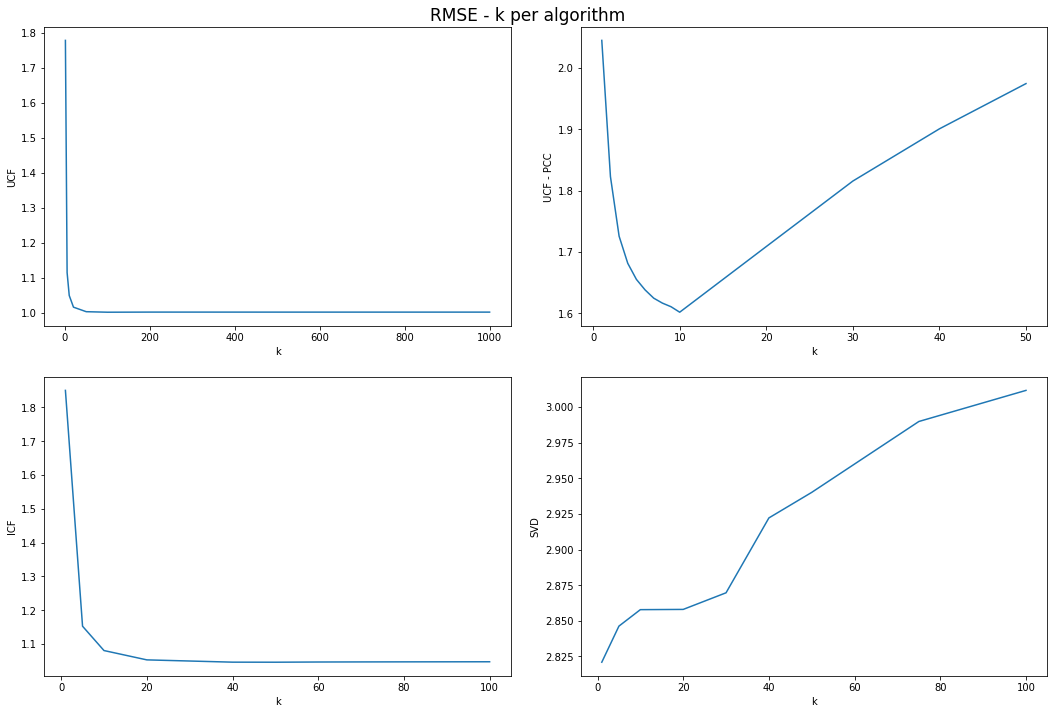

In [136]:
import seaborn as sns

def calculate_rmse_per_k(k_values, predictions):
    rmse_values = list()
    for k in k_values:
        rmse_values.append(mean_squared_error(actual_ratings, predictions[k]))
    return rmse_values


rmse_ucf = calculate_rmse_per_k(ucf_k_values, ucf_predictions_per_k)
data = pd.DataFrame({'k':ucf_k_values, 'UCF':rmse_ucf})
table_data = data.nsmallest(1, 'UCF')


rmse_ucf = calculate_rmse_per_k(ucf_corr_coeff_k_values, ucf_predictions_per_k_centered)
data2 = pd.DataFrame({'k':ucf_corr_coeff_k_values, 'UCF - PCC':rmse_ucf})
table_data2 = data2.nsmallest(1, 'UCF - PCC')


rmse_icf = calculate_rmse_per_k(icf_k_values, icf_predictions_per_k)
data3 = pd.DataFrame({'k':icf_k_values, 'ICF':rmse_icf})
table_data3 = data3.nsmallest(1, 'ICF')


rmse_svd = calculate_rmse_per_k(svd_k_values, svd_predictions_per_k)
data4 = pd.DataFrame({'k':svd_k_values, 'SVD':rmse_svd})
table_data4 = data4.nsmallest(1, 'SVD')


frames = [table_data, table_data2, table_data3, table_data4]
result = pd.concat(frames)
result.set_index('k', inplace=True)


f, axes = plt.subplots(2, 2, figsize=(15,10))
sns.lineplot(x="k", y="UCF", data=data, ax=axes[0,0])
sns.lineplot(x="k", y="UCF - PCC", data=data2, ax=axes[0,1])
sns.lineplot(x="k", y="ICF", data=data3, ax=axes[1,0])
sns.lineplot(x="k", y="SVD", data=data4, ax=axes[1,1])
f.tight_layout(pad=2.0)
f.suptitle('RMSE - k per algorithm', y=1, fontsize=17)
result